In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.metrics import roc_curve,auc

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter


from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#import data
feature_type = 'Ulz'
in_dir = feature_type+'_results/'
metadata_file = '../../../../data/MBC_metadata/merged_tables/key_samples_full_metadata.txt'

probabilities = pd.read_csv(feature_type+'_results/probabilities.txt', sep='\t')
probabilities = probabilities.set_index('sample')

#merge in additional metadata as needed
print(len(probabilities))
metadata_columns = ['patient_id','first_passing_sample','tumor_fraction', 
                    'merged_updated_ER_status_binary','merged_updated_ER_status',
                    'merged_TimeFromMet_ToDeathOrLastFU_Days','merged_DeathCensor',
                    'merged_MetsProgesteroneStatus','merged_ER_switch',
                    'merged_PrimaryEstrogenStatus','merged_MetsEstrogenStatus']

metadata = pd.read_csv(metadata_file,sep='\t')[['sample']+metadata_columns].set_index('sample')

probabilities = probabilities.merge(metadata, left_index=True, right_index=True)
print(len(probabilities))

n_iter = probabilities.drop(columns=['status']+metadata_columns).columns.values.astype('int').max()+1
print(n_iter)
probabilities[[m for m in range(n_iter)]] = probabilities[[str(m) for m in range(n_iter)]]
probabilities = probabilities.drop(columns = [str(m) for m in range(n_iter)])

254
254
1000


In [3]:
#export per sample probabilities
probabilities['median_probability'] = probabilities[np.arange(n_iter)].median(axis=1)
probabilities['median_prediction'] = np.round(probabilities['median_probability']).astype(int)

probabilities[['tumor_fraction','status','median_probability','median_prediction']].to_csv(feature_type+'_results/per_sample_means.txt', sep='\t')


In [4]:
#get unique samples only
probabilities = probabilities[probabilities['first_passing_sample']==1]
print(len(probabilities))
#print number of unique patients
print('unique patients', len(probabilities['patient_id'].unique()))
print('first TFx >0.1',len(probabilities[probabilities['tumor_fraction']>=0.1]['patient_id'].unique()))

139
unique patients 139
first TFx >0.1 101


In [5]:
print('all samples')
print(probabilities['status'].value_counts())

print('high tfx')
print(probabilities[probabilities['tumor_fraction']>=0.1]['status'].value_counts())

print('low tfx')
print(probabilities[probabilities['tumor_fraction']<0.1]['status'].value_counts())

all samples
1    74
0    65
Name: status, dtype: int64
high tfx
0    51
1    50
Name: status, dtype: int64
low tfx
1    24
0    14
Name: status, dtype: int64


In [6]:
#get AUC and accuracy for each bootstrap
AUCs = pd.DataFrame(columns = ['group','AUC'])
accuracies = pd.DataFrame(columns = ['group','accuracy'])
accuracy_df = pd.DataFrame(probabilities['status'])

for i in range(n_iter):
    current = probabilities[~(probabilities[i].isnull())][['status','tumor_fraction',i]].copy()
    
    current['accuracy'] = np.where(np.round(current[i])==current['status'],1,0)
    accuracy_df[i] = current['accuracy']
    low_tfx = current[(current['tumor_fraction']<0.1)]
    high_tfx = current[(current['tumor_fraction']>=0.1)]
    
    for group,df in zip(['overall','high_tfx','low_tfx'],[current,high_tfx,low_tfx]):
        fpr,tpr,_ = roc_curve(df['status'],df[i])
        
        AUC = auc(fpr,tpr)
        AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)
        
        accuracy = sum(np.round(df[i])==df['status'])/len(df)
        accuracies = accuracies.append({'group':group, 'accuracy':accuracy}, ignore_index = True)
    

In [7]:
#calculate confidence intervals
AUC_CI_df = AUCs.groupby('group').mean()
AUC_CI_df = AUC_CI_df.rename(columns = {'AUC':'mean'})

#get CI for each bootstrap
AUC_CI_df['lower'] = AUCs.groupby('group').quantile(.025)
AUC_CI_df['upper'] = AUCs.groupby('group').quantile(.975)
AUC_CI_df['metric']='AUC'

#calculate confidence intervals
accuracy_CI_df = accuracies.groupby('group').mean()
accuracy_CI_df = accuracy_CI_df.rename(columns = {'accuracy':'mean'})

#get CI for each bootstrap
accuracy_CI_df['lower'] = accuracies.groupby('group').quantile(.025)
accuracy_CI_df['upper'] = accuracies.groupby('group').quantile(.975)
accuracy_CI_df['metric']='accuracy'

#merge dataframes together
CI_df = accuracy_CI_df.append(AUC_CI_df).reset_index()

CI_df.to_csv(feature_type+'_results/CI_metrics.txt', sep='\t', index=False)

In [8]:
CI_df

,group,mean,lower,upper,metric
0,high_tfx,0.542462,0.400000,0.684248,accuracy
1,low_tfx,0.558076,0.307692,0.818182,accuracy
2,overall,0.546533,0.420943,0.666667,accuracy
3,high_tfx,0.577597,0.413929,0.736111,AUC
4,low_tfx,0.617702,0.307639,0.933333,AUC
5,overall,0.580315,0.443050,0.716954,AUC


In [9]:
accuracy_df['fraction_correct'] = accuracy_df[np.arange(n_iter)].mean(axis=1)
accuracy_df['median_accuracy'] = np.round(accuracy_df['fraction_correct']).astype(int)
accuracy_df['median_probability'] = probabilities[np.arange(n_iter)].median(axis=1)
accuracy_df['median_prediction'] = np.round(accuracy_df['median_probability']).astype(int)

sample_means = accuracy_df[['status','fraction_correct','median_probability','median_prediction','median_accuracy']].merge(metadata[metadata_columns], left_index=True, right_index=True)
sample_means[['status','tumor_fraction','fraction_correct','merged_ER_switch','merged_updated_ER_status_binary','median_probability','median_prediction','median_accuracy']].to_csv(feature_type+'_results/first_sample_means.txt', sep='\t')

In [10]:
data = sample_means
CI = CI_df

In [11]:
color_dict ={'low_tfx':'tab:olive','high_tfx':'tab:cyan', 'overall':'grey'}

0.5580764188633265
0.5424621803268841
0.5465328432474559


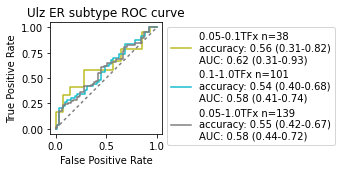

In [12]:
#plot the ROC curves 
fig,ax = plt.subplots(figsize=(6,2.5))

tfxs = [[.05,.1,'low_tfx'],[.1,1.0,'high_tfx'],[0.05,1.0,'overall']]


for minimum,maximum,name in tfxs:
    current = data[(data['tumor_fraction']>=minimum) & (data['tumor_fraction']<maximum)]

    accuracy = CI[(CI['group']==name) & (CI['metric']=='accuracy')]['mean'].values[0]
    print(accuracy)
    
    AUC = CI[(CI['group']==name) & (CI['metric']=='AUC')]['mean'].values[0]
    
    
    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
    #the AUC calculated this way isn't correct (slighlty higher)
    #auc_val = auc(fpr,tpr)
    #print(AUC, auc_val)
    
    #get the CI from the bootstrap data
    lower_acc = CI[(CI['group']==name) & (CI['metric']=='accuracy')]['lower'].values[0]
    upper_acc = CI[(CI['group']==name) & (CI['metric']=='accuracy')]['upper'].values[0]
    lower_AUC = CI[(CI['group']==name) & (CI['metric']=='AUC')]['lower'].values[0]
    upper_AUC = CI[(CI['group']==name) & (CI['metric']=='AUC')]['upper'].values[0]

    label = str(minimum)+'-'+str(maximum)+'TFx n='+str(len(current))+\
        '\naccuracy: '+ format(accuracy,'.2f')+' ('+format(lower_acc, '.2f')+'-'+format(upper_acc, '.2f')+')'+\
        '\nAUC: '+ format(AUC,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'

    
    
    plt.plot(fpr,tpr, label = label, color=color_dict[name])

plt.legend(bbox_to_anchor = [1,1], loc = 'upper left')
plt.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(feature_type+' ER subtype ROC curve')

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(in_dir+feature_type+'_ROC_curves_by_tfx.pdf')